# Introduction and Brief Problem Description
For my final analysis project, I am using the Abalone data from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/1/abalone).  My grandparents lived near the coast in northern California, USA, and I loved it when we could eat the abalone he harvested.

Abalone are a shellfish which live in the crevices of rocky reefs or in kelp beds.  They grow slowly; it can take 12 years to reach 7 inches in diameter, which is small for an abalone.  This makes them vulnerable to overfishing because it takes so many years to replace each abalone taken.  (https://wildlife.ca.gov/Conservation/Marine/Invertebrates/Abalone)

Determining the age of an abalone is similar to finding the age of a tree; the shell is cut and the rings are counted.  In the case of abalone, however, the rings must first be stained and then counted through a microscope.  This is a time consuming process, so the goal of this data analysis is to find a way to determine age using other measurements which can be collected more efficiently.  

## Importing and Preparing Data

In [52]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
import random

from math import exp

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets, metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.base import clone 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, KFold
import scipy as sp
import scipy.stats as stats



plt.style.use('ggplot')
#pd.set_option('max_columns', 200)

In [30]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 

# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 

print(X.info())
print(y.info())
print(X.groupby('Sex').count().Length)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

We see that one feature is categorical and the others are continuous, and there is no missing data.  Within that categorical variable, there are three categories, and from the size of the categories, it is important to keep all three classes.  For this analysis, we will use the original data for linear regression, restrict to non-categorical when building a KNN model, and finally we use one hot encoding on the categorical variable when building models with decision tree and random forest algorithms.  We will create a test and train version of each.

After builing each model, I am going to use the test data to see how my models do.

In [31]:
random.seed(1821)

# For when we use a training set and testing set
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = 0.20)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)


X_train_numeric = X_train.drop(columns = ['Sex'])
X_test_numeric = X_test.drop(columns = ['Sex'])


In [32]:
ohe = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
train_one_hot = ohe.fit_transform(X_train[['Sex']])
feature_labels = np.array(ohe.categories_).ravel()
coh = pd.DataFrame(train_one_hot, columns = feature_labels)
X_train_ohe = pd.concat([X_train_numeric, coh], axis = 1)

test_one_hot = ohe.fit_transform(X_test[['Sex']])
feature_labels = np.array(ohe.categories_).ravel()
coh = pd.DataFrame(test_one_hot, columns = feature_labels)
X_test_ohe = pd.concat([X_test_numeric, coh], axis = 1)


### Exploratory Data Analysis

Here we do some Exploratory Data Analysis.  In addition to a summary of the data, we will look at histograms for each feature (using pairplot), correlation plots and a heatmap. 

In [33]:
print(X.groupby('Sex').count().Length)
print(X_train_numeric.describe())
print(X_train.columns)

Sex
F    1307
I    1342
M    1528
Name: Length, dtype: int64
            Length     Diameter       Height  Whole_weight  Shucked_weight  \
count  3341.000000  3341.000000  3341.000000   3341.000000     3341.000000   
mean      0.523083     0.407152     0.139253      0.823840        0.357732   
std       0.120231     0.099260     0.042016      0.487757        0.220732   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.345000     0.115000      0.438500        0.186000   
50%       0.545000     0.425000     0.140000      0.796000        0.335500   
75%       0.615000     0.480000     0.165000      1.146000        0.498500   
max       0.800000     0.630000     1.130000      2.825500        1.488000   

       Viscera_weight  Shell_weight  
count     3341.000000   3341.000000  
mean         0.179632      0.237122  
std          0.109119      0.138262  
min          0.000500      0.001500  
25%          0.091500      0.130000  
50%     

These numbers did not make sense to me, because adult abalone can be several inches across.  I went back to the data set description and found this note: "the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200)."  We will continue to use the data as we retrieved it, but this is something to keep in mind.

Instead of looking at one-variable histograms individually, I'm going to do a pairplot. 

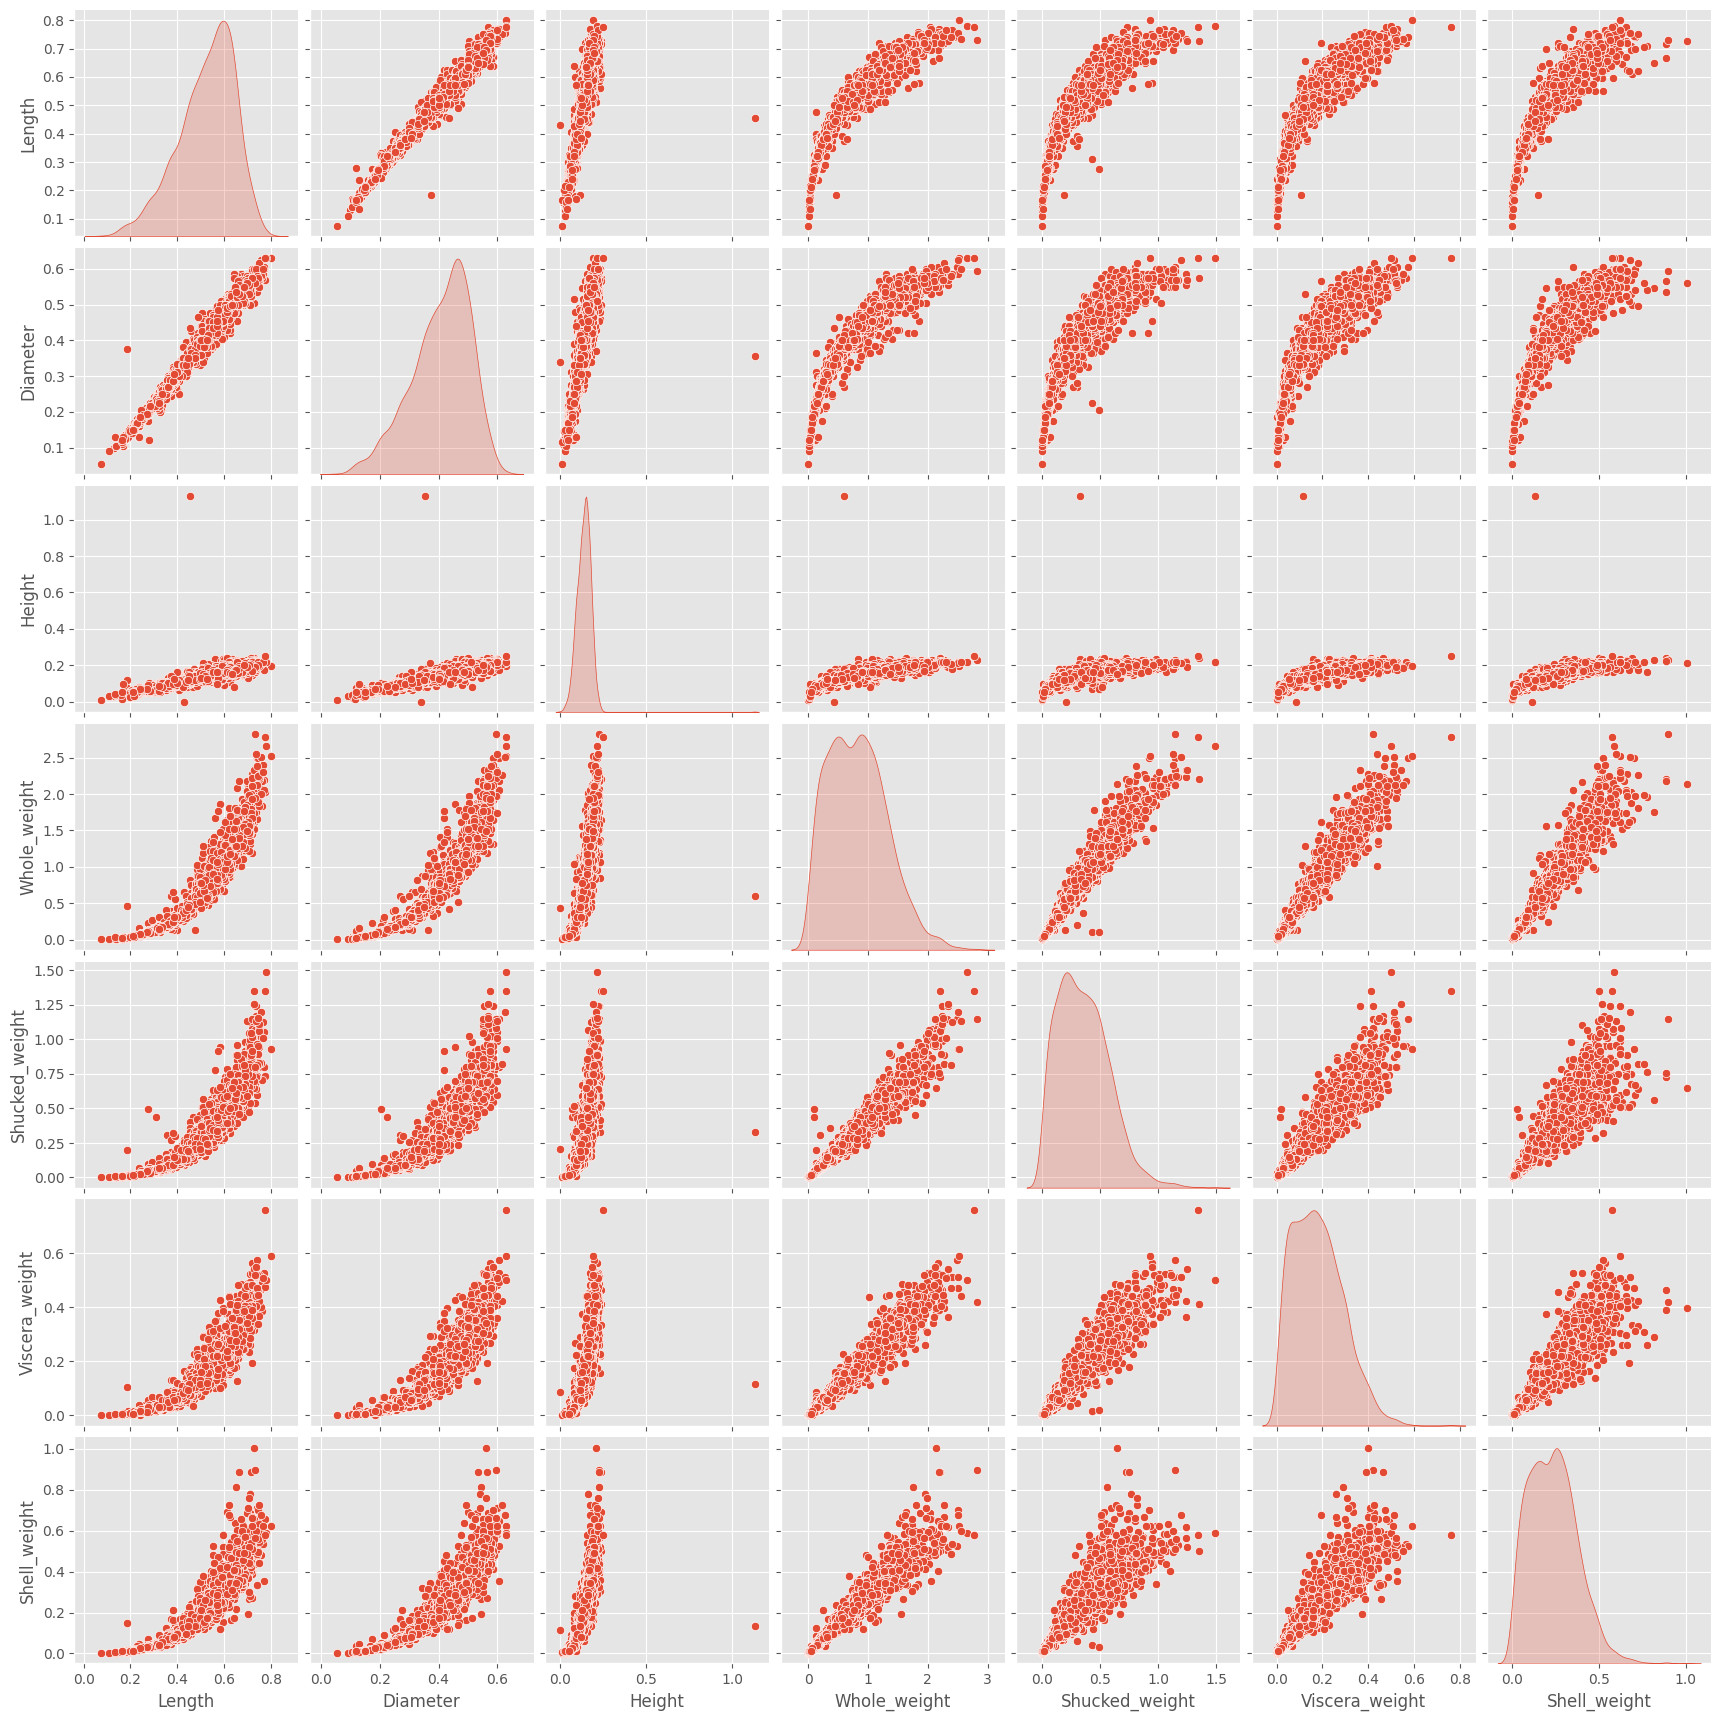

In [34]:
sns.pairplot(X_train_numeric, diag_kind = "kde")

It looks like there is some highly correlated data, especially length and diameter.  And because volume is the cube of length, we aren't surprised to see cubic or cube-root relations between the distance measures (length, diameter, height) and the weight measures.  

<Axes: >

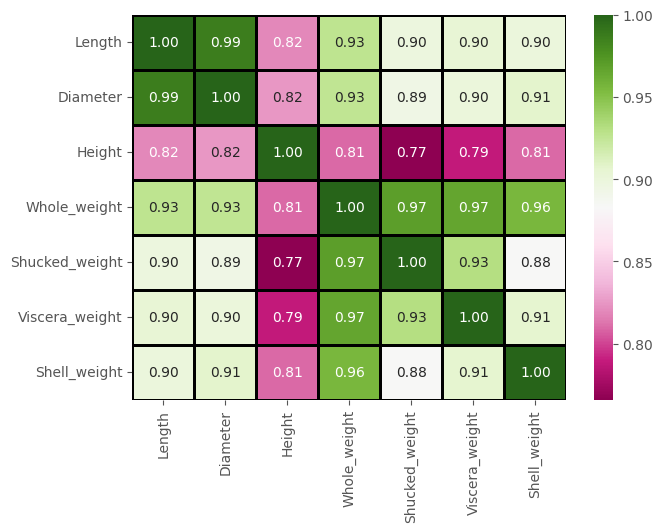

In [35]:
# Check correlation within the features.
X_corr = X_train_numeric.corr()

plt.figure(figsize=(7,5))
sns.heatmap(X_train_numeric.corr(), annot = True, fmt=".2f", cmap = "PiYG", linewidths = 1, linecolor = "black")

Those correlations are all quite high.  This leads me to believe that a Random Forest model will produce the best results, but I will still investigate other models.

So far we haven't looked at the response variable at all.  Here is a plot that helps us see the distribution of number of rings.

Text(0.5, 1.0, 'Rings as a function of length')

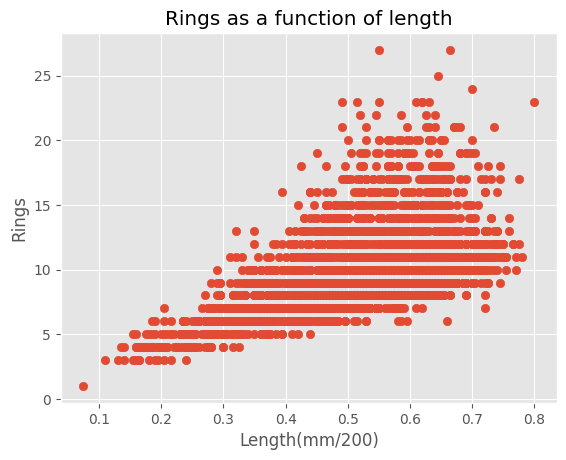

In [36]:
plt.scatter(X_train_numeric.Length, y_train)
plt.xlabel('Length(mm/200)')
plt.ylabel('Rings')
plt.title('Rings as a function of length')

## Analysis
I will start with a short foray into linear regression, consider k-nearest numbers, and finish with decision trees and random forests.

### Linear Regression
None of our EDA leads us to think Linear Regression is the best path because of the high correlation between variables, but a linear model provides a good baseline for future methods. 

In [37]:
df = X_train.copy()
df['Rings'] = y_train
lm = smf.ols('Rings ~ Sex + Length + Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     436.5
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:05:21   Log-Likelihood:                -7340.7
No. Observations:                3341   AIC:                         1.470e+04
Df Residuals:                    3331   BIC:                         1.476e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6655      0.324     11.320      0.000       3.031       4.300
Sex[T.I]          -0.8266      0.114     -7.270      0.000      -1.050      -0.604
Sex[T.M]           0.0421      0.093      0.455      0.649      -0.139       0.224
Length            -0.3582      2.019     -0.177      0.859      -4.317       3.601
Diameter          11.8312      2.481      4.769      0.000       6.968      16.695
Height            10.9461      1.656      6.609      0.000       7.699      14.193
Whole_weight       7.7139      0.802      9.622      0.000       6.142       9.286
Shucked_weight   -18.8238      0.896    -21.008      0.000     -20.581     -17.067
Viscera_weight    -9.3779      1.439     -6.515      0.000     -12.200      -6.556
Shell_weight      10.1826      1.262      8.067      0.000       7.708      12.658
==============================================================================
Omnibus:                      708.648   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.612
Skew:                           1.131   Prob(JB):                         0.00
Kurtosis:                       5.895   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A revised model with only statistically significant variables (I removed 'Length' and 'Sex' one at a time).  I am curious as to why we aren't seeing more signs of multicollinearlity inside the linear model during this process.

In [38]:
df = X_train.copy()
df['Rings'] = y_train
lm = smf.ols('Rings ~ Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     629.2
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:05:21   Log-Likelihood:                -7377.0
No. Observations:                3341   AIC:                         1.477e+04
Df Residuals:                    3334   BIC:                         1.481e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.6553      0.276      9.621      0.000       2.114       3.196
Diameter          12.5231      1.104     11.344      0.000      10.359      14.688
Height            11.9909      1.666      7.196      0.000       8.724      15.258
Whole_weight       7.9240      0.810      9.787      0.000       6.337       9.511
Shucked_weight   -19.2652      0.901    -21.393      0.000     -21.031     -17.500
Viscera_weight    -8.6571      1.442     -6.003      0.000     -11.485      -5.829
Shell_weight      10.1784      1.275      7.985      0.000       7.679      12.678
==============================================================================
Omnibus:                      700.506   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1815.032
Skew:                           1.127   Prob(JB):                         0.00
Kurtosis:                       5.821   Cond. No.                         73.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
yp = np.array(lm.predict(X_test))
yt = np.array(y_test.Rings)
TMSE = np.mean((yp - yt)**2)
print('The test mean squared error is', TMSE)

The test mean squared error is 5.192008377726423


There are so many ways to tune a linear regression model.  Here are the results of models with single features.  Note the significant increase in TMSE.

In [40]:
for col_name in X_train.columns:
    f = 'Rings ~ ' + col_name
    lmod1 = smf.ols(formula = f, data = df).fit()
    yp = np.array(lmod1.predict(X_test))
    TMSE_lm = sum((yp - yt)**2)/len(yp)
    print(round(lmod1.rsquared_adj,4), ' and ', round(TMSE_lm,4), 'are the adjusted R^2 and TMSE respectively for a linear model with predictor', col_name )

0.1973  and  8.7716 are the adjusted R^2 and TMSE respectively for a linear model with predictor Sex
0.3152  and  7.5607 are the adjusted R^2 and TMSE respectively for a linear model with predictor Length
0.336  and  7.3668 are the adjusted R^2 and TMSE respectively for a linear model with predictor Diameter
0.3106  and  7.3255 are the adjusted R^2 and TMSE respectively for a linear model with predictor Height
0.2914  and  7.5061 are the adjusted R^2 and TMSE respectively for a linear model with predictor Whole_weight
0.177  and  8.7502 are the adjusted R^2 and TMSE respectively for a linear model with predictor Shucked_weight
0.2538  and  7.9383 are the adjusted R^2 and TMSE respectively for a linear model with predictor Viscera_weight
0.3955  and  6.5179 are the adjusted R^2 and TMSE respectively for a linear model with predictor Shell_weight


### Polynomial Regression
An investigation of regression models is not complete without looking at models with interactions or polynomial regression.  

In [41]:
lmod2 = smf.ols(formula = 'Rings ~ Shell_weight + Diameter', data = df).fit()
yp = np.array(lmod2.predict(X_test))
TMSE = sum((yp - yt)**2)/len(yp)
print(round(lmod2.rsquared_adj,4), ' and ', round(TMSE,4), 'are the adjusted R^2 and TMSE respectively for a linear model with predictors Shell_weight and Diameter')


lmod_int = smf.ols(formula = 'Rings ~ Shell_weight* Diameter', data = df).fit()
yp = np.array(lmod_int.predict(X_test))
TMSE = sum((yp - yt)**2)/len(yp)
print(round(lmod_int.rsquared_adj,4), ' and ', round(TMSE,4), 'are the adjusted R^2 and TMSE respectively for a linear model with predictors Shell_weight and Diameter with an interaction term.' )

lmod_root = smf.ols(formula = 'Rings ~ Shell_weight + I(Shell_weight**0.3)', data = df).fit()
yp = np.array(lmod_root.predict(X_test))
TMSE = sum((yp - yt)**2)/len(yp)
print(round(lmod_root.rsquared_adj,4), ' and ', round(TMSE,4), 'are the adjusted R^2 and TMSE respectively for a linear model with cube root of Shell_weight.' )

lmod_poly = smf.ols(formula = 'Rings ~ Shell_weight + I(Shell_weight**2) + I(Shell_weight**3)', data = df).fit()
yp = np.array(lmod_poly.predict(X_test))
TMSE = sum((yp - yt)**2)/len(yp)
print(round(lmod_poly.rsquared_adj,4), ' and ', round(TMSE,4), 'are the adjusted R^2 and TMSE respectively for a polynomial model cubic in Shell_weight')

0.3958  and  6.5286 are the adjusted R^2 and TMSE respectively for a linear model with predictors Shell_weight and Diameter
0.4613  and  5.9595 are the adjusted R^2 and TMSE respectively for a linear model with predictors Shell_weight and Diameter with an interaction term.
0.4255  and  6.3045 are the adjusted R^2 and TMSE respectively for a linear model with cube root of Shell_weight.
0.4231  and  6.3398 are the adjusted R^2 and TMSE respectively for a polynomial model cubic in Shell_weight


### KNN (Numeric Data Only)
Now, let's consider a k-nearest neighbor model.  Because KNN uses a metric, I am just going to use the numeric data and ignore the categorical feature 'Sex'.

In [42]:
knn = KNeighborsRegressor(n_neighbors=12, weights='uniform', 
                                       algorithm='auto', leaf_size=30, p=3, 
                                       metric='minkowski', metric_params=None, n_jobs=None)
knn_model = knn.fit(X_train_numeric, y_train)
yp = np.array(knn_model.predict(X_test_numeric))
TMSE = np.mean((yp.reshape(1,-1) - yt)**2)
print('The test mean squared error is', TMSE)

The test mean squared error is 4.943655303030303


In [43]:
X_train_norm = (X_train_numeric - X_train_numeric.mean())/X_train_numeric.std()
X_test_norm = (X_test_numeric - X_test_numeric.mean())/X_test_numeric.std()

knn = KNeighborsRegressor(n_neighbors=2, weights='uniform', 
                                       algorithm='auto', leaf_size=30, p=2, 
                                       metric='minkowski', metric_params=None, n_jobs=None)
knn_model = knn.fit(X_train_norm, y_train)
yp = np.array(knn_model.predict(X_test_norm))
TMSE = np.sum((yp.reshape(1,-1) - yt)**2)/len(yp)
print('The test mean squared error is', TMSE)

The test mean squared error is 7.018540669856459


We could tune the hyperparameters, for example to find a better metric or a more accurate number of neighbors, but this model doesn't seem like the correct path with this data, especially since it doesn't take the categorical variable 'Sex' into consideration, so I'm going to move forward to other models.

### Decision Tree Models
A decision tree model seems like a natural model for this type of data, where there are three distinct categories for one of the features.  Unfortunately, scikit learn does not accept categorical variables in the "DecisionTreeRegressor" and "RandomForestRegressor" classes.  So I used one hot encoding for the categorical variable.

In [44]:
X_train_ohe.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,F,I,M
0,0.450,0.335,0.125,0.3490,0.1190,0.1055,0.1150,0.0,0.0,1.0
1,0.575,0.430,0.155,0.7955,0.3485,0.1925,0.2200,1.0,0.0,0.0
2,0.575,0.450,0.160,1.0680,0.5560,0.2140,0.2575,1.0,0.0,0.0
3,0.545,0.450,0.160,0.8615,0.2925,0.1545,0.3650,0.0,0.0,1.0
4,0.515,0.400,0.160,0.8175,0.2515,0.1560,0.3000,0.0,0.0,1.0


In one hot encoding, we replace the categories M, F and I by the 3-tuples (0,0,1), (1,0,0) and (0,1,0) respectively.  If we wanted to do linear regression with this data, we would need to delete one of the columns to avoid collinearity, but decision tree models and random forest models can be fed all three columns.

In [45]:
md = 10
mln = 15
dtr = DecisionTreeRegressor(max_depth = md, max_leaf_nodes = mln)
trained_dtr = dtr.fit(X_train_ohe, y_train)
yp = np.array(trained_dtr.predict(X_test_ohe))

TMSE = np.mean((yp - yt)**2)
print('The test mean squared error is', TMSE)

The test mean squared error is 5.93665916437823


### Random Forests

RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                     oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
                     ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

In [46]:
rfr = RandomForestRegressor()
rfr_model = rfr.fit(X_train_ohe, np.array(y_train).ravel())
yp = np.array(rfr_model.predict(X_test_ohe))

TMSE = np.sum((yp - yt)**2)/len(yp)
print('The test mean squared error is', TMSE)

The test mean squared error is 5.246772009569378


C:\Users\eltur\AppData\Local\Temp\ipykernel_25564\541626319.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


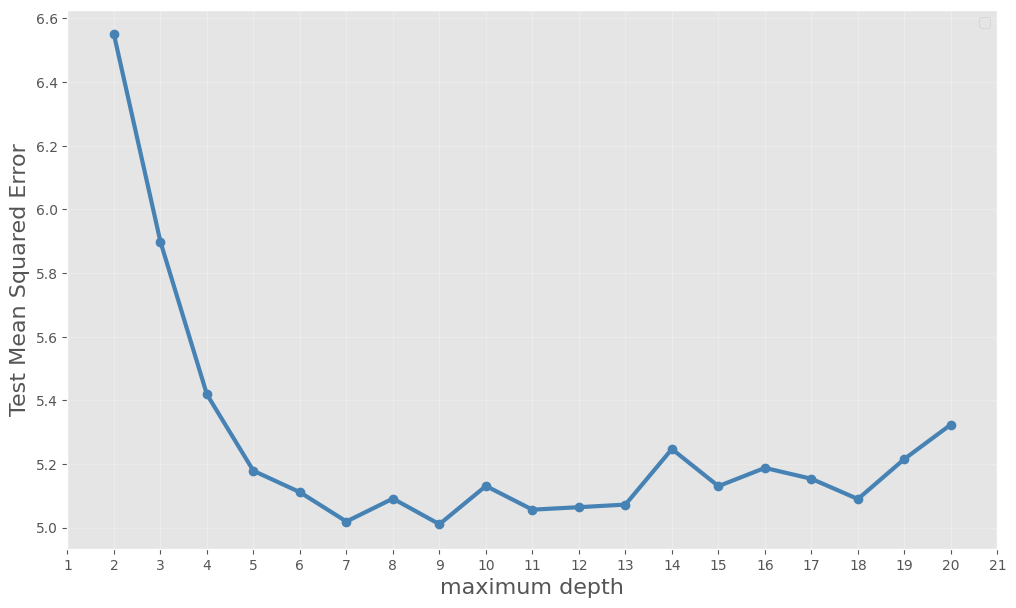

In [47]:
allmaxd = range(2,21)
tmse = []

# your code here
for i in allmaxd:
    rfr = RandomForestRegressor(max_depth = i)
    model_rf = rfr.fit(X_train_ohe, np.array(y_train).ravel())
    y_pred = np.array(model_rf.predict(X_test_ohe))
    TMSE = np.mean((y_pred - yt)**2)
    tmse.append(TMSE)
    
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allmaxd, tmse, marker="o", color="steelblue", lw=3)
ax.set_xlabel("maximum depth", fontsize=16)
ax.set_ylabel("Test Mean Squared Error", fontsize=16)
plt.xticks(range(1,22,1))
ax.legend()
ax.grid(alpha=0.25)




7.667610918464563
6.828325033685895
6.490354098940771
6.180680124347277
5.910354421597931
5.701690307037136
5.612044753323293
5.490075446756183
5.415933732321199
5.3656165864353635
5.3476676006930255
5.309634848868177
5.27295296188154
5.242909285583726
5.214891503549239
5.226289732079662
5.198677547330574
5.164146854389579
5.1699535499016


C:\Users\eltur\AppData\Local\Temp\ipykernel_25564\2613210296.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


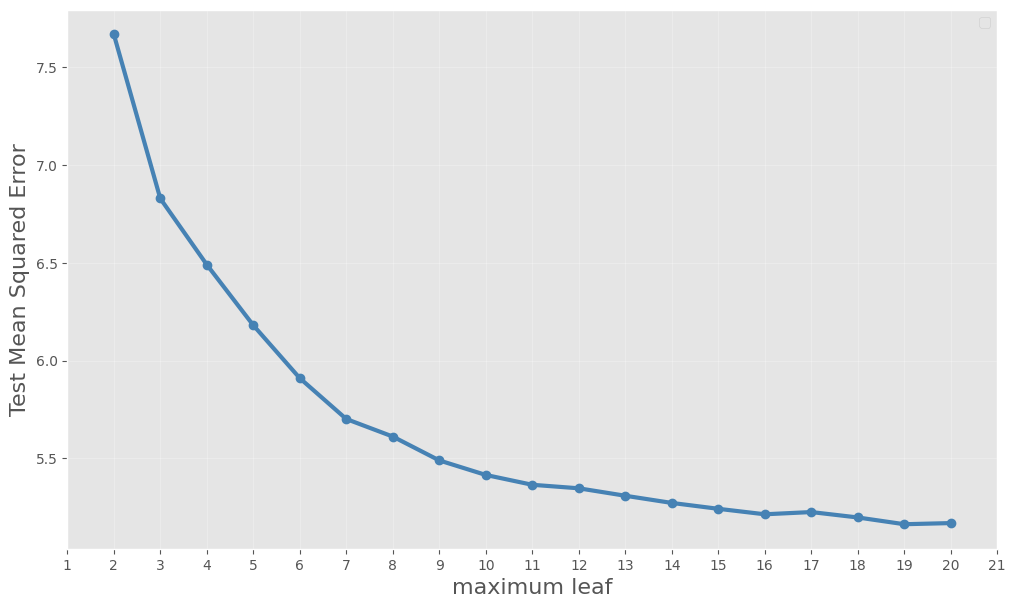

In [48]:
allmaxleaf = range(2,21)
tmse = []

# your code here
for i in allmaxleaf:
    rfr = RandomForestRegressor(max_leaf_nodes=i)
    model_rf = rfr.fit(X_train_ohe, np.array(y_train).ravel())
    y_pred = np.array(model_rf.predict(X_test_ohe))
    TMSE = np.sum((y_pred - yt)**2)/len(yp)
    print(TMSE)
    tmse.append(TMSE)
    
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allmaxleaf, tmse, marker="o", color="steelblue", lw=3)
ax.set_xlabel("maximum leaf", fontsize=16)
ax.set_ylabel("Test Mean Squared Error", fontsize=16)
plt.xticks(range(1,22,1))
ax.legend()
ax.grid(alpha=0.25)

In [49]:
rfr = RandomForestRegressor(max_leaf_nodes=10, max_depth = 8)
model_rf = rfr.fit(X_train_ohe, np.array(y_train).ravel())
y_pred = np.array(model_rf.predict(X_test_ohe))
TMSE = np.sum((y_pred - yt)**2)/len(yp)
print(TMSE)
tmse.append(TMSE)

5.425320621184825


### k-fold Cross Validation

So, there's really a problem with this analysis, which is when I change the random number generation, the TSE on the models changes considerably, like from 5 to 15.  I don't know what to do about that except to do k-fold cross validation.

In [50]:
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=False, random_state=None)
kf.get_n_splits(df)
print(kf)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"fold{i}:")
    print(f"  Train: index = {train_index}")
    print(f"  Test:  index = {test_index}")

KFold(n_splits=5, random_state=None, shuffle=False)
fold0:
  Train: index = [ 836  837  838 ... 4174 4175 4176]
  Test:  index = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214

In [56]:
ohe = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
cols_one_hot = ohe.fit_transform(X[['Sex']])
feature_labels = np.array(ohe.categories_).ravel()
coh = pd.DataFrame(cols_one_hot, columns = feature_labels)
X_ohe = pd.concat([X.drop(columns = ['Sex']), coh], axis = 1)


  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  
0         0.150  
1         0.070  
2         0.210  
3         0.155  
4         0.055  


,Rings
0,15
1,7
2,9
3,10
4,7
...,...
4172,11
4173,10
4174,9
4175,10


In [66]:
model = RandomForestRegressor(
        min_samples_leaf=5, random_state=0
    )

pg ={"n_estimators": [10, 20, 50, 100]}

cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
grid_search = GridSearchCV(
    estimator=model,
    param_grid = pg,
    return_train_score=True,
    cv=cv,
).fit(X_ohe, np.array(y).ravel())
pd.DataFrame(grid_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.133159,0.008908,0.007218,0.007238,10,{'n_estimators': 10},0.544857,0.521416,0.497062,0.547599,0.527733,0.020424,4,0.763441,0.767825,0.770864,0.766008,0.767035,0.002704
1,0.254447,0.009650,0.008742,0.004276,20,{'n_estimators': 20},0.554424,0.535752,0.505171,0.555558,0.537726,0.020375,3,0.773187,0.772248,0.777567,0.777211,0.775053,0.002362
2,0.660494,0.025864,0.012341,0.004540,50,{'n_estimators': 50},0.557164,0.549310,0.522110,0.553384,0.545492,0.013782,2,0.781623,0.777126,0.782780,0.781935,0.780866,0.002200
3,1.228169,0.021698,0.026268,0.006337,100,{'n_estimators': 100},0.562056,0.551581,0.526660,0.554628,0.548731,0.013300,1,0.782506,0.780603,0.784857,0.783586,0.782888,0.001560


In [71]:
kfold = KFold(100, shuffle=True)

results = sklearn.model_selection.cross_validate(
    linear_model.LinearRegression(),
    df.drop(columns = 'Rings'),
    df.Rings,
    cv=kfold,
    scoring="r2", 
    return_train_score=True,
    return_estimator=True,
)

validation_error = results["test_score"]
print('R-squared:',validation_error.mean())
validation_error

R-squared: 0.49905178899470193


array([ 0.52879935,  0.45632542,  0.62614054, -0.80748562,  0.51187311,
        0.27242165,  0.48057646,  0.69584416,  0.46513685,  0.45077035,
        0.55493978,  0.55301943,  0.32311483,  0.66067602,  0.61640881,
        0.58965944,  0.6639059 ,  0.25047326,  0.65353252,  0.59054578,
        0.69638634,  0.40954605,  0.60133576,  0.21445644,  0.78635775,
        0.71187039,  0.56746019,  0.42046983,  0.45604585,  0.49422218,
        0.32274019,  0.50680564,  0.45458908,  0.72652237,  0.52045502,
        0.65830204,  0.62181903,  0.63603606,  0.72619905,  0.34071706,
        0.59760079,  0.62169481,  0.31327149,  0.40787416,  0.20704077,
        0.51834333,  0.46833743,  0.56869286,  0.51378309,  0.45890273,
        0.62768883,  0.46640932,  0.61576481,  0.2253673 ,  0.41977086,
        0.59301003,  0.4781123 ,  0.47246639,  0.67498837,  0.51070771,
        0.50715427,  0.49971861,  0.55852439,  0.43255474,  0.39360603,
        0.41694273,  0.78479086,  0.55153407,  0.62932579,  0.51

## Conclusion
I will write a conclusion for here.